<a href="https://colab.research.google.com/github/PatriciaUdorji/Mental-Health-Chatbot/blob/main/350_Epoch_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import string
import re
import pandas as pd
from google.colab import files
import io
import pickle

In [ ]:
# Upload CSV file in Colab
uploaded = files.upload()

# Load dataset
filename = next(iter(uploaded.keys()))
data = pd.read_csv(io.BytesIO(uploaded[filename]), sep=",", encoding="ISO-8859-1")


Saving counselchat-data 4.csv to counselchat-data 4.csv


In [ ]:
# Replace missing 'questionText' with 'questionTitle'
data['questionText'].fillna(data['questionTitle'], inplace=True)

In [ ]:
# Drop rows where 'questionText', 'questionTitle', 'topics', or 'answerText' have missing values
data.dropna(subset=['questionText', 'questionTitle', 'topics', 'answerText'], inplace=True)


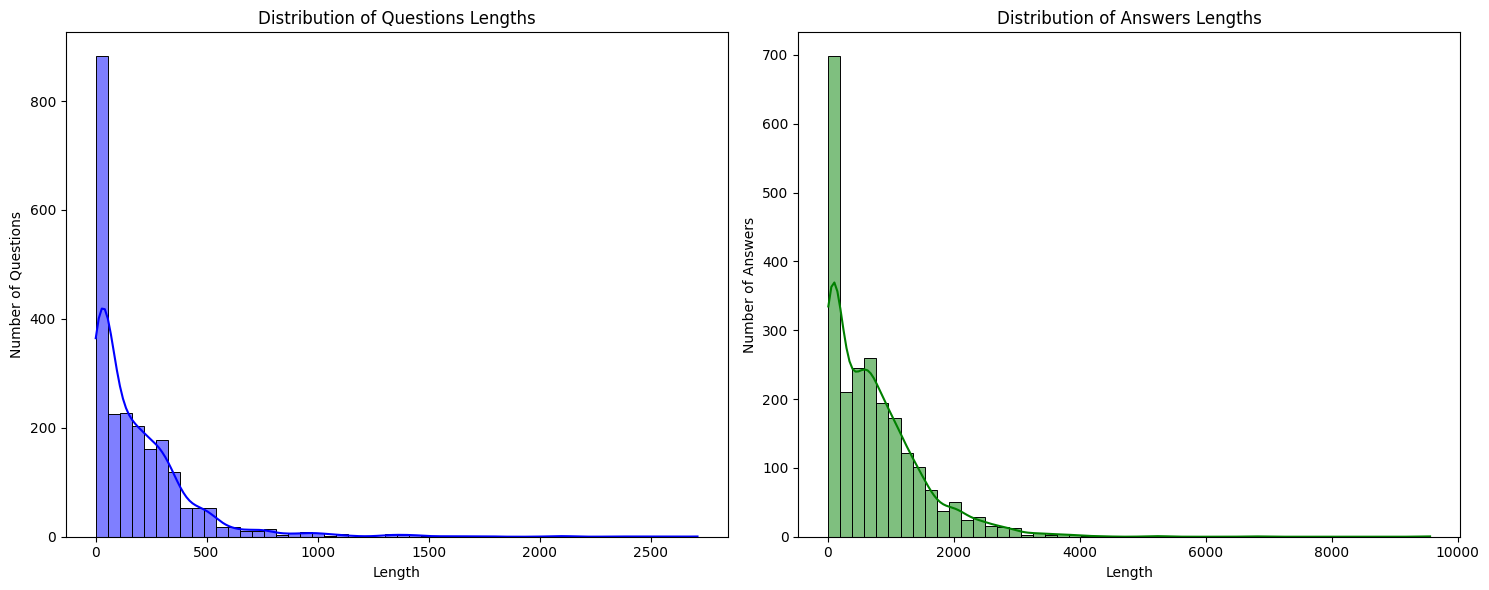

In [ ]:
# Importing necessary libraries and loading the data again
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


# Extract questions and answers
questions = data['questionText'].astype(str)
answers = data['answerText'].astype(str)

# Calculate lengths
questions_lengths = questions.apply(len)
answers_lengths = answers.apply(len)

# Generating the plots
plt.figure(figsize=(15, 6))

# Plotting questions lengths
plt.subplot(1, 2, 1)
sns.histplot(questions_lengths, bins=50, color='blue', kde=True)
plt.title('Distribution of Questions Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Questions')

# Plotting answers lengths
plt.subplot(1, 2, 2)
sns.histplot(answers_lengths, bins=50, color='green', kde=True)
plt.title('Distribution of Answers Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Answers')

plt.tight_layout()
plt.show()


In [ ]:

# Contractions mapping
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
}

def expand_contractions(text, contractions_dict):
    # Iterate over the contractions and expand them
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    return text

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Replace newlines with space
    text = text.replace('\n', ' ')

    # Remove specific HTML tags
    tags = ['div', 'br', 'span', 'li', 'p']
    for tag in tags:
        text = re.sub(r'</?{}.*?>'.format(tag), ' ', text)

    # Remove general HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove HTML entities
    text = re.sub(r'&[a-z]+;', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+', ' ', text)

    # Expand contractions
    text = expand_contractions(text, contractions)

    # Remove punctuations
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove special characters but retain spaces
    text = re.sub(r'[^a-z\s]', '', text)

    return text


In [ ]:
# Cleaning the data
data['questionText_cleaned'] = data['questionText'].astype(str).apply(clean_text)
data['answerText_cleaned'] = data['answerText'].astype(str).apply(clean_text)
data['questionTitle_cleaned'] = data['questionTitle'].astype(str).apply(clean_text)
data['topics_cleaned'] = data['topics'].astype(str).apply(clean_text)

In [ ]:
  import itertools

# Extract questions and answers
questionsclean = data['questionTitle_cleaned'].astype(str)
answersclean = data['answerText_cleaned'].astype(str)

# Tokenize the questions and answers
tokenized_questions = [q.split() for q in questionsclean]
tokenized_answers = [a.split() for a in answersclean]

# Flatten the lists and count occurrences
question_word_counts = Counter(itertools.chain(*tokenized_questions))
answer_word_counts = Counter(itertools.chain(*tokenized_answers))

# Get the most common words and their counts
most_common_question_words = question_word_counts.most_common(20)
most_common_answer_words = answer_word_counts.most_common(20)

most_common_question_words, most_common_answer_words

([('i', 1402),
  ('my', 856),
  ('how', 618),
  ('to', 514),
  ('do', 458),
  ('can', 370),
  ('a', 332),
  ('is', 303),
  ('and', 271),
  ('with', 252),
  ('me', 228),
  ('what', 227),
  ('of', 205),
  ('the', 202),
  ('about', 185),
  ('im', 173),
  ('feel', 166),
  ('have', 165),
  ('it', 155),
  ('get', 146)],
 [('you', 12262),
  ('to', 11434),
  ('the', 7466),
  ('and', 7169),
  ('a', 6400),
  ('your', 5552),
  ('that', 5344),
  ('is', 5259),
  ('of', 5110),
  ('in', 3889),
  ('are', 3714),
  ('it', 3161),
  ('with', 3064),
  ('be', 3031),
  ('for', 2703),
  ('can', 2511),
  ('this', 2468),
  ('i', 2455),
  ('or', 2416),
  ('if', 2335)])

In [ ]:
# Get the least common words and their counts
least_common_question_words = question_word_counts.most_common()[-20:]
least_common_answer_words = answer_word_counts.most_common()[-20:]
least_common_question_words, least_common_answer_words

([('identify', 1),
  ('outside', 1),
  ('addict', 1),
  ('ruin', 1),
  ('opiates', 1),
  ('postpartum', 1),
  ('treatable', 1),
  ('conditions', 1),
  ('coexist', 1),
  ('describe', 1),
  ('trigger', 1),
  ('developing', 1),
  ('depession', 1),
  ('generalized', 1),
  ('strategies', 1),
  ('most', 1),
  ('effective', 1),
  ('recovery', 1),
  ('preventing', 1),
  ('myths', 1)],
 [('palpitations', 1),
  ('distressyour', 1),
  ('gadfind', 1),
  ('roleresearch', 1),
  ('includethe', 1),
  ('parentshaving', 1),
  ('bullyinghaving', 1),
  ('arthritishaving', 1),
  ('misusebut', 1),
  ('conditionmore', 1),
  ('includetalking', 1),
  ('servicemedication', 1),
  ('selective', 1),
  ('serotonin', 1),
  ('reuptake', 1),
  ('inhibitors', 1),
  ('ssriswith', 1),
  ('courseexercising', 1),
  ('regularlystopping', 1),
  ('smokinglooking', 1)])

In [ ]:

# Apply tags immediately after cleaning
data['questionTitle_tagged'] = ["<Q> " + str(question) + " </Q>" for question in data['questionTitle_cleaned']]
data['answerText_tagged'] = ["<A> " + str(answer) + " </A>" for answer in data['answerText_cleaned']]


# Using the tagged questions and answers for tokenization and model training
questions = data['questionTitle_tagged'].tolist()
answers = data['answerText_tagged'].tolist()

# Compute word frequencies using Keras Tokenizer
initial_tokenizer = Tokenizer(filters='', lower=False)
initial_tokenizer.fit_on_texts(questions + answers)

# Identify words that appear only once
infrequent_words = [word for word, count in initial_tokenizer.word_counts.items() if count == 1]


# Initialize the main tokenizer excluding infrequent words
tokenizer = Tokenizer(filters='', lower=False, oov_token='OOV')
tokenizer.fit_on_texts(questions + answers)


# Manually adjust the word index to exclude infrequent words
for word in infrequent_words:
    del tokenizer.word_index[word]
    del tokenizer.word_docs[word]
    del tokenizer.word_counts[word]


# Convert text to sequences
questions_seq = tokenizer.texts_to_sequences(questions)
answers_seq = tokenizer.texts_to_sequences(answers)

# Determine the maximum lengths separately for questions and answers
maxlen_questions = max(len(seq) for seq in questions_seq)
maxlen_answers = max(len(seq) for seq in answers_seq)

# Pad sequences to their respective maximum lengths
questions_seq_padded = pad_sequences(questions_seq, maxlen=maxlen_questions, padding='post')
answers_seq_padded = pad_sequences(answers_seq, maxlen=maxlen_answers, padding='post')

# Extract the vocab size from the tokenizer
VOCAB_SIZE = len(tokenizer.word_index) + 1  # +1 for padding token

print(VOCAB_SIZE)




5594


In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
import numpy as np


In [ ]:
from tensorflow.keras import preprocessing, utils

# Encoder input data
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
padded_questions = preprocessing.sequence.pad_sequences(tokenized_questions, maxlen=maxlen_questions, padding='post')
encoder_input_data = np.array(padded_questions)
print(encoder_input_data.shape, maxlen_questions)

(2279, 29) 29


In [ ]:
# Decoder input data
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
padded_answers = preprocessing.sequence.pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
decoder_input_data = np.array(padded_answers)
print(decoder_input_data.shape, maxlen_answers)

(2279, 927) 927


In [ ]:
# Decoder output data (shifted version of decoder_input_data)
tokenized_answers = tokenizer.texts_to_sequences(answers)
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]  # Removing the start token
padded_answers = preprocessing.sequence.pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
decoder_output_data = np.array(padded_answers)
print(decoder_output_data.shape)


(2279, 927)


In [ ]:
import tensorflow as tf

# Hyperparameters
embedding_dim = 256
rnn_units = 256
epochs = 350
batch_size = 10
learning_rate = 0.001  # Adjustable learning rate

# Using the separate maximum lengths for questions and answers
maxlen_questions = max(len(seq) for seq in questions_seq)
maxlen_answers = max(len(seq) for seq in answers_seq)

# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(maxlen_questions,))
encoder_embedding = tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dim, mask_zero=True)(encoder_inputs)
x = encoder_embedding
x, state_h, state_c = tf.keras.layers.LSTM(rnn_units, return_state=True)(x)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(maxlen_answers,))
decoder_embedding = tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dim, mask_zero=True)(decoder_inputs)
x = decoder_embedding

# Explicitly define the LSTM layer for the decoder
decoder_lstm = tf.keras.layers.LSTM(rnn_units, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = tf.keras.layers.Dense(VOCAB_SIZE, activation=tf.keras.activations.softmax)
output = decoder_dense(decoder_outputs)

# Model
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Reshape decoder_output_data for sparse categorical crossentropy
decoder_output_data = decoder_output_data.reshape((-1, maxlen_answers, 1))

# Assuming encoder_input_data, decoder_input_data, decoder_output_data are defined elsewhere
history = model.fit(
    [encoder_input_data, decoder_input_data], decoder_output_data,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

# Displaying accuracy for the final epoch
print(f"Accuracy for the final epoch: {history.history['accuracy'][-1]:.4f}")

model_name = f'seq2seq_chatbot_1_layer_lr_{learning_rate}.h5'
model.save(model_name)
print(f"Model with 1 LSTM layer and learning rate {learning_rate} saved as {model_name}")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 29)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 927)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 29, 256)      1432064     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 927, 256)     1432064     ['input_2[0][0]']                
                                                                                              

In [ ]:
# Encoder inference model
encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

# Decoder inference model
decoder_state_input_h = tf.keras.layers.Input(shape=(256,))
decoder_state_input_c = tf.keras.layers.Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.models.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


In [ ]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index['<A>']

    decoded_sentence = ''
    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample the next token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, 'OOV')

        # Exit the loop if the sampled word is the ending tag or if the sentence becomes too long.
        if (sampled_word == '</A>' or len(decoded_sentence.split()) > maxlen_answers):
            break

        decoded_sentence += ' ' + sampled_word

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()



In [ ]:
def preprocess_user_input(text):
    '''Clean and tag user input to match training data preprocessing'''
    text = clean_text(text)
    text = "<Q> " + text + " </Q>"
    return text

while True:
    user_input = input("You: ")
    if user_input.lower() in ["quit", "exit", "bye"]:
        break

    # Preprocess the user's input
    preprocessed_user_input = preprocess_user_input(user_input)

    tokenized_user_input = tokenizer.texts_to_sequences([preprocessed_user_input])
    padded_user_input = pad_sequences(tokenized_user_input, maxlen=maxlen_questions, padding='post')
    chatbot_response = decode_sequence(padded_user_input)
    print('Chatbot:', chatbot_response)


You: Hello
1/1 [==============================] - 0s 21ms/step
Chatbot: how can i help
You: i want to end it
1/1 [==============================] - 0s 22ms/step
Chatbot: i am so sorry that this is the first step to look at what feelings of your anxiety also i think it is great that you are reaching out there a lot of people consider having a plan when and not worthy of this relationship and many times it can be hard to do what is best for you but i would encourage you to seek out a professional counselor
You: ok
1/1 [==============================] - 0s 21ms/step
Chatbot: come come elucidate your thoughts
You: ok
1/1 [==============================] - 0s 21ms/step
Chatbot: come come elucidate your thoughts
You: bye


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = "/content/drive/My Drive/layer350epoch.h5"
model.save(model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/My Drive/layer350epoch.h5


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Sample interactions
interactions = [
    {
        "prompt": "I am so burned out",
        "chatbot_response": "give yourself a break go easy on yourself",
        "ideal_response": "give yourself a break. go easy on yourself"
    },
    {
        "prompt": "I feel so lonely",
        "chatbot_response": "how long have you been feeling this way",
        "ideal_response": "how long have you been feeling this way"
    },
    {
        "prompt": "My sister passed away",
        "chatbot_response": "im sorry to hear that if you want to talk about it im here",
        "ideal_response": "im sorry to hear that if you want to talk about it im here"
    },
    {
        "prompt": "Who is at risk of anxiety?",
        "chatbot_response": "if you have a lot of depression that is more than just about your symptoms and your feelings many people have thoughts of anxiety and depression but can also affect fathers OOV with no reason but do come with and how to manage problems with a mental health condition depression is the normal eating as a depressive disorder obsessivecompulsive disorder or substance abusewe believe that eating disorders are related to a combination of biologic psychologic and social factors eating disorders are associated with other psychiatric illnesses such as substance use disorder depression anxiety and obsessivecompulsive disorder like other psychiatric illnesses they tend to run in families which suggests an underlying genetic component",
        "ideal_response": "if you have a family member with an anxiety disorder, you have a higher chance of developing one"
    },
    {
        "prompt": "What is anxiety?",
        "chatbot_response": "anxiety is defined as a state of OOV uncertainty and fear resulting from OOV of the illness enough so much to us on social media i know that i have felt the most important thing is to tell your parents that can help you with your current therapist depending on the state legally and OOV a OOV of the clients issues sometimes the therapist is not progressing and they are giving any information or other with this type of termination maybe final or mental illness it sounds like a very young age when we are not OOV to those feelings differently a sense of people will follow the ability to get rid of our own in order to protect us when we are always out their own stuff with people who are not able to handle it it sounds like they have a lot of things about what they are getting back",
        "ideal_response": "anxiety is a natural response to a stressful or dangerous situation"
    },
    {
        "prompt": "What is depression",
        "chatbot_response": "depression is a medical condition just like diabetes or heart disease day after day low selfesteem thoughts thoughts etc sometimes if you have difficulty initiating OOV as a child having family members if you have been experiencing symptoms for depression without being aware of the age of this and the person who has or OOV of symptoms due to the symptoms you experienced takes OOV it will be hard to know more about your symptoms and OOV you also have been been physically and physically responsible for your OOV for example many people have postnatal depression is more than simply feeling unhappy or fed up for a long time in the way you may be able to find one on the type of eating disorder you may be offered behavioural couples therapy",
        "ideal_response": "depression is a mood disorder with symptoms that affect a person's thoughts feelings behavior and daily functioning In some severe cases it can also lead to thoughts of death or attempts at self-harm or suicide"
    },
    {
        "prompt": "I have depression",
        "chatbot_response": "sometimes when we are depressed it is hard to care about anything it can be hard to do the simplest of things give yourself time to heal",
        "ideal_response": "talk to me tell me more it helps if you open up yourself to someone else"
    },
    {
        "prompt": "Can a lack of sleep cause depression?",
        "chatbot_response": "no lack of sleep alone cannot cause depression it does not make it long but it may also be helpful to seek help",
        "ideal_response": "no lack of sleep alone cannot cause depression it does play a role"
    },
    {
        "prompt": "Who is at risk of anxiety?",
        "chatbot_response": "if you have a lot of depression that is more than just about your symptoms and your feelings many people have thoughts of anxiety and depression but can also affect fathers OOV with no reason but do come with and how to manage problems with a mental health condition depression is the normal eating as a depressive disorder obsessivecompulsive disorder or substance abusewe believe that eating disorders are related to a combination of biologic psychologic and social factors eating disorders are associated with other psychiatric illnesses such as substance use disorder depression anxiety and obsessivecompulsive disorder like other psychiatric illnesses they tend to run in families which suggests an underlying genetic component",
        "ideal_response": "If you have a family member with an anxiety disorder, you have a higher chance of developing one"
    },
    {
        "prompt": "Tell me about yourself",
        "chatbot_response": "im chatbot a therapeutic ai assitant designed to assist you tell me about yourself",
        "ideal_response": "im chatbot"
    },
    {
        "prompt": "I need support",
        "chatbot_response": "sure tell me how can i assist you",
        "ideal_response": "sure tell me how can i assist you"
    },

]

# Calculate BLEU for each interaction
bleu_scores = []
for interaction in interactions:
    reference = [interaction["ideal_response"].split()]
    candidate = interaction["chatbot_response"].split()
    bleu = sentence_bleu(reference, candidate)
    bleu_scores.append(bleu)

# Calculate average BLEU
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu:.4f}")



Average BLEU Score: 0.3484


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_